## from https://web.stanford.edu/~boyd/papers/admm/

# Code

In [1]:
code = grabcode("https://web.stanford.edu/~boyd/papers/admm/group_lasso/group_lasso.html")


code =

    'function [z, history] = group_lasso(A, b, lambda, p, rho, alpha)
     % group_lasso  Solve group lasso problem via ADMM
     %
     % [x, history] = group_lasso(A, b, p, lambda, rho, alpha);
     % 
     % solves the following problem via ADMM:
     %
     %   minimize 1/2*|| Ax - b ||_2^2 + \lambda sum(norm(x_i))
     %
     % The input p is a K-element vector giving the block sizes n_i, so that x_i
     % is in R^{n_i}.
     % 
     % The solution is returned in the vector x.
     %
     % history is a structure that contains the objective value, the primal and 
     % dual residual norms, and the tolerances for the primal and dual residual 
     % norms at each iteration.
     % 
     % rho is the augmented Lagrangian parameter. 
     %
     % alpha is the over-relaxation parameter (typical values for alpha are 
     % between 1.0 and 1.8).
     %
     %
     % More information can be found in the paper linked at:
     % http://www.stanford.edu/~boyd/papers/distr_opt_s

In [2]:
%%file group_lasso.m

function [z, history] = group_lasso(A, b, lambda, p, rho, alpha)
% group_lasso  Solve group lasso problem via ADMM
%
% [x, history] = group_lasso(A, b, p, lambda, rho, alpha);
%
% solves the following problem via ADMM:
%
%   minimize 1/2*|| Ax - b ||_2^2 + \lambda sum(norm(x_i))
%
% The input p is a K-element vector giving the block sizes n_i, so that x_i
% is in R^{n_i}.
%
% The solution is returned in the vector x.
%
% history is a structure that contains the objective value, the primal and
% dual residual norms, and the tolerances for the primal and dual residual
% norms at each iteration.
%
% rho is the augmented Lagrangian parameter.
%
% alpha is the over-relaxation parameter (typical values for alpha are
% between 1.0 and 1.8).
%
%
% More information can be found in the paper linked at:
% http://www.stanford.edu/~boyd/papers/distr_opt_stat_learning_admm.html
%

t_start = tic;

%% Global constants and defaults

QUIET    = 0;
MAX_ITER = 1000;
ABSTOL   = 1e-4;
RELTOL   = 1e-2;

%% Data preprocessing

[m, n] = size(A);

% save a matrix-vector multiply
Atb = A'*b;
% check that sum(p) = total number of elements in x
if (sum(p) ~= n)
    error('invalid partition');
end

% cumulative partition
cum_part = cumsum(p);

%% ADMM solver

x = zeros(n,1);
z = zeros(n,1);
u = zeros(n,1);

% pre-factor
[L U] = factor(A, rho);

if ~QUIET
    fprintf('%3s\t%10s\t%10s\t%10s\t%10s\t%10s\n', 'iter', ...
      'r norm', 'eps pri', 's norm', 'eps dual', 'objective');
end

for k = 1:MAX_ITER

    % x-update
    q = Atb + rho*(z - u);    % temporary value
    if( m >= n )    % if skinny
       x = U \ (L \ q);
    else            % if fat
       x = q/rho - (A'*(U \ ( L \ (A*q) )))/rho^2;
    end

    % z-update
    zold = z;
    start_ind = 1;
    x_hat = alpha*x + (1-alpha)*zold;
    for i = 1:length(p),
        sel = start_ind:cum_part(i);
        z(sel) = shrinkage(x_hat(sel) + u(sel), lambda/rho);
        start_ind = cum_part(i) + 1;
    end
    u = u + (x_hat - z);

    % diagnostics, reporting, termination checks
    history.objval(k)  = objective(A, b, lambda, cum_part, x, z);

    history.r_norm(k)  = norm(x - z);
    history.s_norm(k)  = norm(-rho*(z - zold));

    history.eps_pri(k) = sqrt(n)*ABSTOL + RELTOL*max(norm(x), norm(-z));
    history.eps_dual(k)= sqrt(n)*ABSTOL + RELTOL*norm(rho*u);


    if ~QUIET
        fprintf('%3d\t%10.4f\t%10.4f\t%10.4f\t%10.4f\t%10.2f\n', k, ...
            history.r_norm(k), history.eps_pri(k), ...
            history.s_norm(k), history.eps_dual(k), history.objval(k));
    end

    if (history.r_norm(k) < history.eps_pri(k) && ...
       history.s_norm(k) < history.eps_dual(k))
         break;
    end

end

if ~QUIET
    toc(t_start);
end
end

function p = objective(A, b, lambda, cum_part, x, z)
    obj = 0;
    start_ind = 1;
    for i = 1:length(cum_part),
        sel = start_ind:cum_part(i);
        obj = obj + norm(z(sel));
        start_ind = cum_part(i) + 1;
    end
    p = ( 1/2*sum((A*x - b).^2) + lambda*obj );
end

function z = shrinkage(x, kappa)
    z = pos(1 - kappa/norm(x))*x;
end

function [L U] = factor(A, rho)
    [m, n] = size(A);
    if ( m >= n )    % if skinny
       L = chol( A'*A + rho*speye(n), 'lower' );
    else            % if fat
       L = chol( speye(m) + 1/rho*(A*A'), 'lower' );
    end

    % force matlab to recognize the upper / lower triangular structure
    L = sparse(L);
    U = sparse(L');
end

Created file '/home/wenh06/Jupyter/wenhao/workspace/fl_seminar/code/boyd-admm/group_lasso.m'.


# Example

In [3]:
eg_code = grabcode("https://web.stanford.edu/~boyd/papers/admm/group_lasso/group_lasso_example.html")


eg_code =

    '% Group lasso example with random data
     
     %% Generate problem data
     
     randn('seed', 0);
     rand('seed',0);
     
     m = 1500;       % amount of data
     K = 200;        % number of blocks
     partition = randi(50, [K 1]);
     
     n = sum(partition); % number of features
     p = 100/n;          % sparsity density  
     
     % generate block sparse solution vector
     x = zeros(n,1);
     start_ind = 1;
     cum_part = cumsum(partition);
     for i = 1:K,
         x(start_ind:cum_part(i)) = 0;
         if( rand() < p)
             % fill nonzeros
             x(start_ind:cum_part(i)) = randn(partition(i),1);
         end
         start_ind = cum_part(i)+1;
     end
     
     % generate random data matrix
     A = randn(m,n);
     
     % normalize columns of A
     A = A*spdiags(1./norms(A)',0,n,n);
     
     % generate measurement b with noise
     b = A*x + sqrt(0.001)*randn(m,1);
     
     % lambda max
     start_ind = 1;
     for i = 1

### Generate problem data

In [4]:
randn('seed', 0);
rand('seed',0);

m = 1500;       % amount of data
K = 200;        % number of blocks
partition = randi(50, [K 1]);

n = sum(partition); % number of features
p = 100/n;          % sparsity density

% generate block sparse solution vector
x = zeros(n,1);
start_ind = 1;
cum_part = cumsum(partition);
for i = 1:K,
    x(start_ind:cum_part(i)) = 0;
    if( rand() < p)
        % fill nonzeros
        x(start_ind:cum_part(i)) = randn(partition(i),1);
    end
    start_ind = cum_part(i)+1;
end

% generate random data matrix
A = randn(m,n);

% normalize columns of A
A = A*spdiags(1./norms(A)',0,n,n);

% generate measurement b with noise
b = A*x + sqrt(0.001)*randn(m,1);

% lambda max
start_ind = 1;
for i = 1:K,
    sel = start_ind:cum_part(i);
    lambdas(i) = norm(A(:,sel)'*b);
    start_ind = cum_part(i) + 1;
end
lambda_max = max(lambdas);

% regularization parameter
lambda = 0.1*lambda_max;

xtrue = x;   % save solution

### Solve problem

In [5]:
[x history] = group_lasso(A, b, lambda, partition, 1.0, 1.0);

iter	    r norm	   eps pri	    s norm	  eps dual	 objective
  1	    4.5636	    0.0575	    1.1081	    0.0529	      5.75
  2	    2.6711	    0.0528	    2.5802	    0.0781	     15.56
  3	    1.1275	    0.0729	    2.8105	    0.0858	     21.82
  4	    0.9624	    0.0954	    2.3289	    0.0836	     24.10
  5	    1.1278	    0.1114	    1.6552	    0.0776	     24.57
  6	    1.1015	    0.1205	    1.0314	    0.0707	     24.56
  7	    0.9163	    0.1243	    0.5703	    0.0649	     24.20
  8	    0.6773	    0.1245	    0.3388	    0.0605	     23.65
  9	    0.4594	    0.1228	    0.2927	    0.0576	     23.04
 10	    0.2979	    0.1203	    0.2849	    0.0560	     22.46
 11	    0.2006	    0.1179	    0.2548	    0.0552	     22.01
 12	    0.1524	    0.1160	    0.2063	    0.0551	     21.69
 13	    0.1264	    0.1146	    0.1535	    0.0553	     21.51
 14	    0.1050	    0.1137	    0.1069	    0.0557	     21.43
 15	    0.0835	    0.1133	    0.0714	    0.0562	     21.42
 16	    0.0633	    0.1132	    0.0477	    0.0565	     21

### Reporting

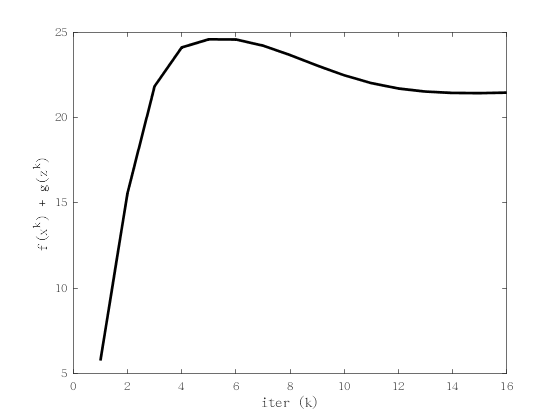

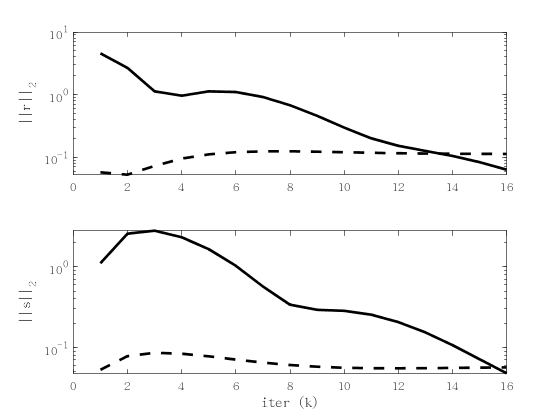

In [6]:
K = length(history.objval);

h = figure;
plot(1:K, history.objval, 'k', 'MarkerSize', 10, 'LineWidth', 2);
ylabel('f(x^k) + g(z^k)'); xlabel('iter (k)');

g = figure;
subplot(2,1,1);
semilogy(1:K, max(1e-8, history.r_norm), 'k', ...
    1:K, history.eps_pri, 'k--',  'LineWidth', 2);
ylabel('||r||_2');

subplot(2,1,2);
semilogy(1:K, max(1e-8, history.s_norm), 'k', ...
    1:K, history.eps_dual, 'k--', 'LineWidth', 2);
ylabel('||s||_2'); xlabel('iter (k)');